In [5]:
import logging
import string
import os
import pickle
from pprint import pprint
import re 
import numpy as np
import pandas as pd
from IPython.display import clear_output
from more_itertools import chunked

# NLTK
import nltk
from nltk.corpus import stopwords

# Gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim

# SpaCy 
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# Logging if you want it
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Suppressing it should you want to
logging.getLogger().setLevel(logging.CRITICAL)

# Suppressing warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#SKLearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text


In [96]:
path=os.listdir(r"C:\Users\Li\Desktop\三国LDA")
datalist=[]
#len(path)

for i in path:
    domain= "C:\\Users\\Li\\Desktop\\三国LDA\\"+i
    #print(domain)
    
    with open(domain,"r",encoding="utf-8") as f:
        data=f.read()
        #print(data)
        datalist.append(data)
len(datalist)

705

In [113]:
no_tabs=[txt.replace('- ','').replace('\t', ' ').replace('\n', ' ').replace("S'pore",'') for txt in datalist]

data2 = [re.sub(r'[^a-zA-Z\.:@]',' ',txt) for txt in no_tabs]
               

no_url = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', txt) for txt in data2]


no_mail=[re.sub('[{a-zA-Z1-9]+@ globaltimes.com.cn','',txt) for txt in no_url ]

refine = [re.sub(r'\s+', ' ', txt) for txt in no_mail]

data9=[txt.replace('Ma es','Macaes').replace('.','').replace(':','').replace('Page Editor','').replace('SOURCE BUSINESS BRIFOCUS','').replace('Belt and Road Initiative','BRI').replace('Belt and Road','BRI').replace('PR Newswire Association','').replace('The Straits Times','').replace('All Rights Reserved','').replace('Singapore Press Holdings Limited ','') for txt in refine]

data=[txt.strip() for txt in data9]

data[500]

'CGTN China s Solutions to Pandemic hit Global Economy Cooperation and Opening up CGTN PR Newswire words November  PR Newswire Asia PRNASI English Copyright c  LLC  BEIJING Nov PRNewswire The COVID pandemic has spread at an alarming pace infecting millions and bringing economic activity to a near standstill as countries impose tight restrictions on movement to contain the spread of the virus How can the global economy recover from this unprecedented blow In his keynote speech via video link at the opening ceremony of the third China International Import Expo CIIE on Wednesday Chinese President Xi Jinping offered the answer from China upholding the principles of mutually beneficial cooperation and mutual opening up Mutually beneficial cooperation COVID is a stark reminder that all countries are bound together as a community with a shared future Xi said adding that no one can stay immune in a major crisis and countries must work together as partners with each shouldering its due responsi

In [114]:
def tokenizer(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(text, deacc=True))

token_list=list(tokenizer(data))
token_list[0][0]

'asianreview'

In [124]:
# Build bigram and trigram models
# min_count = min amount of tokens/bigrams in corpus. Threshold = score-based; higher = fewer phrases.
bigram = gensim.models.Phrases(token_list, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[token_list], threshold=100)  

# `Phraser` must be built from an initial `Phrases` instance. 
# It then works faster while using much less memory. See https://radimrehurek.com/gensim/models/phrases.html
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop = set(stopwords.words('english')+['asianview','viewpoint','sourceupdate','sourcespotlight','gt','end','china','prnewswire','stimes','prn','english','words','llc'])


def remove_stopwords(texts):
    return [[word for word in doc if word not in stop] for doc in texts]
      
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for doc in texts:
        joined = nlp(" ".join(doc)) 
     
        texts_out.append([token.lemma_ for token in joined if token.pos_ in allowed_postags])
    return texts_out

In [125]:
tokens_no_stops = remove_stopwords(token_list)


In [126]:
# Form trigrams
trigrams = make_trigrams(tokens_no_stops)

# Do lemmatization 
lemmas = lemmatization(trigrams)

In [128]:
# Create Dictionary 
dictionary = corpora.Dictionary(lemmas)

# Create Corpus, i.e. Document-Term Matrix
corpus = [dictionary.doc2bow(text) for text in lemmas]

In [129]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           # eval_every = 20, # this is evaluation, perplexity
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [130]:
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.173447  0.143432       1        1  23.906080
0     -0.206326 -0.000191       2        1  21.092109
14    -0.153703  0.214453       3        1  11.198378
2     -0.176450  0.038269       4        1   7.954435
8     -0.073151 -0.164501       5        1   7.061327
9     -0.099059 -0.177410       6        1   3.714956
17    -0.086256 -0.188247       7        1   3.693322
19    -0.111396 -0.099207       8        1   3.255714
12    -0.087111 -0.201694       9        1   3.170221
11    -0.039965  0.119167      10        1   3.003208
4     -0.023367  0.093118      11        1   2.482169
3      0.027422  0.040302      12        1   2.006862
1     -0.004796  0.097019      13        1   1.976903
5      0.025735  0.024533      14        1   1.515098
15     0.086340  0.128607      15        1   1.257641
16     0.185575  0.018492      16        1   0.639834
6      0.212782 -0.019777      17        1   0.599793
13     0.216638 -0.058274      18        1   0.559048
18     0.243676 -0.004716      19        1   0.546493
10     0.236856 -0.003376      20        1   0.366408, topic_info=           Term         Freq        Total Category  logprob  loglift
15          bri  2036.000000  2036.000000  Default  30.0000  30.0000
24      country  2636.000000  2636.000000  Default  29.0000  29.0000
203     project  1104.000000  1104.000000  Default  28.0000  28.0000
41        india   695.000000   695.000000  Default  27.0000  27.0000
645   singapore   983.000000   983.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
82        study     3.457932   234.382362  Topic20  -5.0940   1.3929
2045        lab     2.595326    35.662445  Topic20  -5.3810   2.9888
2193  treatment     2.853998    72.919667  Topic20  -5.2860   2.3685
47    institute     3.052990   185.883155  Topic20  -5.2186   1.5002
815    response     2.454636   165.629810  Topic20  -5.4367   1.3974

[1307 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3549      1  0.334940    abuse
3549      2  0.055823    abuse
3549     11  0.111647    abuse
3549     12  0.502410    abuse
7663      7  0.847309  acclime
...     ...       ...      ...
5589      4  0.909770   ziyang
471       1  0.055347     zone
471       2  0.459384     zone
471       4  0.442780     zone
471       8  0.038743     zone

[3564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 15, 3, 9, 10, 18, 20, 13, 12, 5, 4, 2, 6, 16, 17, 7, 14, 19, 11])

In [131]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=lemmas, dictionary=dictionary, coherence='c_v') 
# The higher the better. A coherence score of .4 means probably not right number of topics; .6 is great. Anything more is suspiciously great.
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Perplexity:  -8.359341919494588

Coherence Score:  0.4218840112535103
Wall time: 14.4 s


In [132]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = limit / step
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, 
                                chunksize=500, passes=10, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values

In [133]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmas, start=10, limit=50, step=5)

Built 1 of 10.0 models
Built 2 of 10.0 models
Built 3 of 10.0 models
Built 4 of 10.0 models
Built 5 of 10.0 models
Built 6 of 10.0 models
Built 7 of 10.0 models
Built 8 of 10.0 models


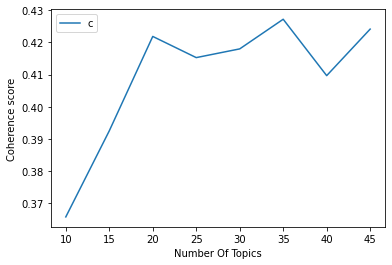

In [134]:
# Show graph
limit=50; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number Of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig("C:\\Users\\Li\\Desktop\\Image.jpg")
plt.show()